In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

In [24]:
ds = load_dataset("microsoft/cats_vs_dogs", split='train')

In [25]:
print(ds)

Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})


In [26]:
ds.shape

(23410, 2)

In [27]:
print("Mix of our dataset :")
print(f"{np.mean(ds['labels'])*100:.2f}% of dog images")
print(f"{(1 - np.mean(ds['labels']))*100:.2f}% of cat images")

Mix of our dataset :
49.85% of dog images
50.15% of cat images


In [28]:
np.mean(ds['labels'])

0.49846219564288763

In [29]:
label_catdogs = {
    0:"Cat",
    1:"Dog"
    }

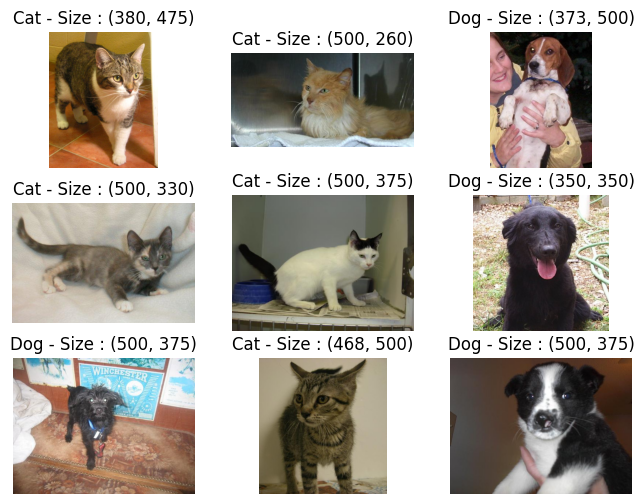

In [30]:
label_catdogs = {
    0:"Cat",
    1:"Dog"
}

fig, ax = plt.subplots(3, 3, figsize=(8, 6))
ax = ax.flatten()

for i in range(9):
    randomInt = np.random.randint(ds.shape[0])
    ax[i].set_title(f"{label_catdogs[ds[randomInt]['labels']]} - Size : {ds[randomInt]['image'].size}")
    ax[i].axis("off")
    ax[i].imshow(ds[randomInt]["image"])
    
plt.axis("off")
plt.show()

---

RESIZING THE IMAGES

In [31]:
images_sizes = [ds[i]['image'].size for i in range(ds.shape[0])]

In [32]:
widths, heights = zip(*images_sizes)

average_width, average_height = int(sum(widths) / len(widths)), int(sum(heights) / len(heights))

print(f"Average size of the images from the dataset is {average_width, average_height}")

Average size of the images from the dataset is (409, 364)


In [33]:
average_size = (409, 364)

In [34]:
# ds['image']

In [35]:
image = ds[0]['image'] # y accéder de cette manière et surtout pas comme ça : ds['image'][0]

In [36]:
desired_size = (256, 256)

In [37]:
import torch
from torchvision import io, transforms

# Définir la transformation de redimensionnement avec l'interpolation 'nearest'
resize_transform = transforms.Resize(desired_size, interpolation=transforms.InterpolationMode.NEAREST)

transform = transforms.Compose([
    transforms.ToTensor()  # Convertit l'image PIL en tenseur PyTorch
]) # normalise directement entre 0 et 1

In [38]:
def resize_and_convert(example):
    image = example['image']
    
    # Convertir en RGB si nécessaire
    if image.mode == "L" or image.mode == "CMYK":
        image = image.convert('RGB')

    # Appliquer la transformation de redimensionnement
    image = resize_transform(image)  

    return {"image": image}  # Retourner l'image modifiée

# Appliquer la fonction à tout le dataset
ds = ds.map(resize_and_convert)

In [39]:
images_sizes = [ds[i]['image'].size for i in range(ds.shape[0])]

In [40]:
widths, heights = zip(*images_sizes)

average_width, average_height = int(sum(widths) / len(widths)), int(sum(heights) / len(heights))

print(f"Average size of the images from the dataset is {average_width, average_height}")

Average size of the images from the dataset is (256, 256)


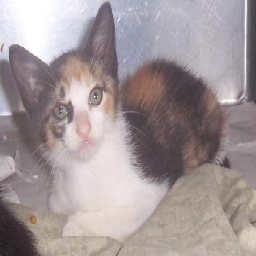

In [57]:
ds[21]['image']

---

Dataset Loaders

In [42]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image

In [43]:
# Diviser le dataset en ensembles d'entraînement et de test
datasets = ds.train_test_split(test_size=0.3, seed=42)
train_dataset = datasets['train']
test_dataset = datasets['test']

In [44]:
print(f"Shape of X_train : {train_dataset.shape[0]}")
print(f"Shape of X_test : {test_dataset.shape[0]}")
print(f"Shape of y_train : {train_dataset.shape[0]}")
print(f"Shape of y_test : {test_dataset.shape[0]}")

Shape of X_train : 16387
Shape of X_test : 7023
Shape of y_train : 16387
Shape of y_test : 7023


In [45]:
print("Mix of our dataset :")
print(f"{(1-(np.sum((train_dataset['labels']))/train_dataset.shape[0]))*100:.2f}% of cat images in train set")
print(f"{(1-(np.sum((test_dataset['labels']))/test_dataset.shape[0]))*100:.2f}% of cat images in test set")

Mix of our dataset :
50.45% of cat images in train set
49.45% of cat images in test set


In [46]:
# Définir les transformations pour l'entraînement
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Retourne l'image horizontalement avec une probabilité de 0.5
    transforms.RandomVerticalFlip(p=0.5),    # Retourne l'image verticalement avec une probabilité de 0.5
    transforms.RandomRotation(degrees=15),  # Effectue une rotation aléatoire jusqu'à 15 degrés
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Modifie aléatoirement la luminosité, le contraste, etc.
    transforms.ToTensor(),  # Convertit l'image en tenseur PyTorch
])

# Définir les transformations pour le test (généralement sans augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convertit l'image en tenseur PyTorch
])

In [ ]:
def transform_image(batch, transform):
    images = []
    for image_data in batch['image']:
        if isinstance(image_data, np.ndarray):  
            image = Image.fromarray(image_data)  # Convertir NumPy -> PIL
        elif isinstance(image_data, Image.Image):  
            image = image_data  # L'image est déjà en format PIL, ne pas rouvrir
        else:
            image = Image.open(image_data)  # Ouvrir normalement si c'est un fichier ou BytesIO
        
        image = transform(image)  # Appliquer la transformation
        images.append(image)

    return {'image': images, 'labels': batch['labels']}  

In [48]:
# Appliquer les transformations aux datasets
train_dataset.set_transform(lambda x: transform_image(x, train_transforms))
test_dataset.set_transform(lambda x: transform_image(x, test_transforms))

In [49]:
# Créer des DataLoader pour les ensembles d'entraînement et de test
dataloader_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=16, shuffle=False)

---

MODEL

In [63]:
# Définir le modèle CNN

import torchvision.models as models

model = models.resnet18(weights=True)

c:\miniconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
# model
# model.fc

In [65]:
for param in model.parameters():
    param.requires_grad = False

In [66]:
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 1) # 1 for the binary classification

In [67]:
# Instancier le modèle, la fonction de perte et l'optimiseur

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss when you have outputs which aren't bounded (that's the case because the final layer is a dense layer without sigmoïd for instance)
optimizer = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)  # Divise lr par 2 tous les 2 epochs

In [69]:
# Entraîner le modèle
num_epochs = 10
train_losses = []
test_losses = []
accuracies = []

# Early stopping parameters
patience = 4
best_loss = np.inf
counter = 0

for epoch in range(num_epochs):
    # Mode entraînement
    model.train()
    train_loss = 0.0

    for batch_idx, batch in enumerate(dataloader_train):
        # Forward pass
        images = batch['image']
        labels = batch['labels']

        outputs = model(images).squeeze()
        #print(outputs)
        loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()

        train_loss += loss.item()

        if batch_idx % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(dataloader_train)}], Loss: {loss.item():.4f}')

    # Calculer la perte moyenne sur l'ensemble de l'époque d'entraînement
    train_loss /= len(dataloader_train)
    train_losses.append(train_loss)

    # Mode évaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx_test, batch_test in enumerate(dataloader_test):
            images = batch_test['image']
            labels = batch_test['labels']

            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()

            # Calculer l'exactitude
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculer la perte moyenne et l'exactitude sur l'ensemble de l'époque de test
    test_loss /= len(dataloader_test)
    accuracy = 100 * correct / total

    accuracies.append(accuracy)    
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
        # Saving the model
        torch.save(model.state_dict(), 'best_model.pth')

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")

            break

model.load_state_dict(torch.load('best_model.pth'))
print("Training and evaluation complete.")

Epoch [1/10], Step [0/1025], Loss: 0.7791
Epoch [1/10], Step [50/1025], Loss: 0.3974
Epoch [1/10], Step [100/1025], Loss: 0.3995
Epoch [1/10], Step [150/1025], Loss: 0.2835
Epoch [1/10], Step [200/1025], Loss: 0.3997
Epoch [1/10], Step [250/1025], Loss: 0.3063
Epoch [1/10], Step [300/1025], Loss: 0.2855
Epoch [1/10], Step [350/1025], Loss: 0.3005
Epoch [1/10], Step [400/1025], Loss: 0.1821
Epoch [1/10], Step [450/1025], Loss: 0.2343
Epoch [1/10], Step [500/1025], Loss: 0.5057
Epoch [1/10], Step [550/1025], Loss: 0.3317
Epoch [1/10], Step [600/1025], Loss: 0.2849
Epoch [1/10], Step [650/1025], Loss: 0.1349
Epoch [1/10], Step [700/1025], Loss: 0.3133
Epoch [1/10], Step [750/1025], Loss: 0.3258
Epoch [1/10], Step [800/1025], Loss: 0.0724
Epoch [1/10], Step [850/1025], Loss: 0.2109
Epoch [1/10], Step [900/1025], Loss: 0.0768
Epoch [1/10], Step [950/1025], Loss: 0.3183
Epoch [1/10], Step [1000/1025], Loss: 0.0863
Epoch [1/10], Train Loss: 0.2958, Test Loss: 0.0836, Accuracy: 97.25%
Epoch [2

In [70]:
train_losses

[0.29582752975748805,
 0.2474476465364782,
 0.23359689721519628,
 0.2298769756588267,
 0.23093999258992148,
 0.22404336504456474,
 0.2261053628347269,
 0.2238129793280145,
 0.21813087149545915,
 0.22120999962818333]

In [71]:
train_losses # I complexified the model

[0.29582752975748805,
 0.2474476465364782,
 0.23359689721519628,
 0.2298769756588267,
 0.23093999258992148,
 0.22404336504456474,
 0.2261053628347269,
 0.2238129793280145,
 0.21813087149545915,
 0.22120999962818333]

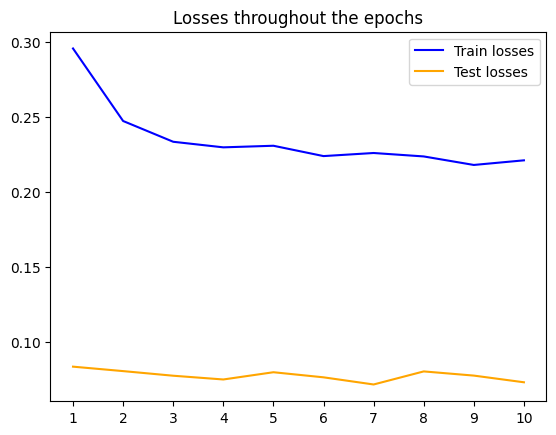

In [72]:
plt.plot(np.arange(1, num_epochs+1), train_losses, color="blue", label="Train losses")
plt.plot(np.arange(1, num_epochs+1), test_losses, color="orange", label="Test losses")

plt.title("Losses throughout the epochs")
plt.xticks(np.arange(1, num_epochs+1, 1))

plt.legend()
plt.show()

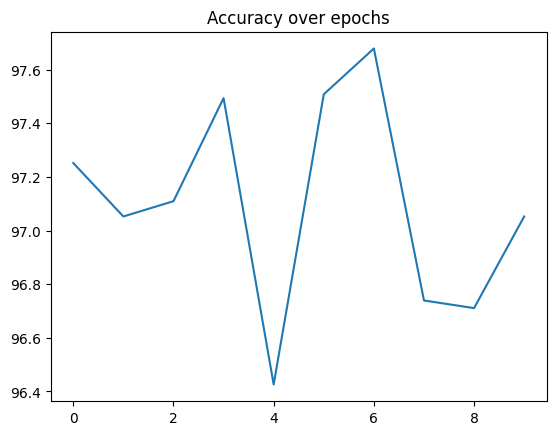

In [73]:
plt.title("Accuracy over epochs")
plt.plot(accuracies)